# 데이터 획득

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 데이터 경로
data_path = '/content/drive/MyDrive/cloud_ai/프로젝트2/'

train = pd.read_csv( data_path + 'train.csv', index_col='id')
test  = pd.read_csv( data_path + 'test.csv', index_col='id')
submission = pd.read_csv( data_path + 'sample_submission.csv')

# original 데이터 불러오기
orig_train = pd.read_csv('/content/drive/MyDrive/cloud_ai/프로젝트2/creditcard.csv')

- orinal 데이터까지 학습하면 데이터 양이 늘어났기 때문에 학습 효과가 상승할 것이다
- 하지만 kaggle에서 orinial 데이터는 주어진 데이터와 특성이 모두 같지는 않다고 한다 -> 주어진 데이터와 비교하여 사용할지 결정

In [3]:
train.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0


In [4]:
test.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
id,,,,,,,,,,,,,,,,,,,,,
219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,-0.230126,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,1.068183,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50


In [5]:
orig_train.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [6]:
train.shape, test.shape, submission.shape, orig_train.shape

((219129, 31), (146087, 30), (146087, 2), (284807, 31))

# 데이터 준비 + EDA

## 피처 요약 함수 구성 - 차후 계속 사용(업그레이드)

In [7]:
def summary_feature_info( df, train=train ):
    sum_df = pd.DataFrame( train.dtypes, columns=['type'])   
    # 인덱스 -> 컬럼으로 이동
    sum_df = sum_df.reset_index()
    # 컬럼명 index -> feature_name 변경
    sum_df.rename( columns={ 'index':'feature_name' }, inplace=True)

    # 결측치수
    sum_df['결측치수'] = train.isnull().sum().values

    # 고유값수
    sum_df['고유값수'] = train.nunique().values

    # 샘플값0~2(0,1,2개정도)
    sum_df['샘플값0'] = train.loc[0].values
    sum_df['샘플값1'] = train.loc[1].values
    sum_df['샘플값2'] = train.loc[2].values

    return sum_df

summary_df = summary_feature_info( train )
summary_df

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,Time,float64,0,36845,0.000000,0.000000,0.000000
1,V1,float64,0,217723,2.074329,1.998827,0.091535
2,V2,float64,0,217729,-0.129425,-1.250891,1.004517
3,V3,float64,0,217700,-1.137418,-0.520969,-0.223445
4,V4,float64,0,217715,0.412846,-0.894539,-0.435249
5,V5,float64,0,217661,-0.192638,-1.122528,0.667548
6,V6,float64,0,217594,-1.210144,-0.270866,-0.988351
7,V7,float64,0,217735,0.110697,-1.029289,0.948146
8,V8,float64,0,217679,-0.263477,0.050198,-0.084789
9,V9,float64,0,217681,0.742144,-0.109948,-0.042027


- 데이터는 전부 수치형이다 -> 인코딩 필요 X
- LGBM을 사용하지만 스케일링을 적용하는 것이 성능에 도움이 된다는 것을 확인하였다 -> MinMaxscaler로 스케일링

## 결측치 확인

In [8]:
# 결측치 확인 -> 결측치 없다
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219129 entries, 0 to 219128
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    219129 non-null  float64
 1   V1      219129 non-null  float64
 2   V2      219129 non-null  float64
 3   V3      219129 non-null  float64
 4   V4      219129 non-null  float64
 5   V5      219129 non-null  float64
 6   V6      219129 non-null  float64
 7   V7      219129 non-null  float64
 8   V8      219129 non-null  float64
 9   V9      219129 non-null  float64
 10  V10     219129 non-null  float64
 11  V11     219129 non-null  float64
 12  V12     219129 non-null  float64
 13  V13     219129 non-null  float64
 14  V14     219129 non-null  float64
 15  V15     219129 non-null  float64
 16  V16     219129 non-null  float64
 17  V17     219129 non-null  float64
 18  V18     219129 non-null  float64
 19  V19     219129 non-null  float64
 20  V20     219129 non-null  float64
 21  V21     21

In [9]:
# 결측치 확인 -> 결측치 없다
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146087 entries, 219129 to 365215
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    146087 non-null  float64
 1   V1      146087 non-null  float64
 2   V2      146087 non-null  float64
 3   V3      146087 non-null  float64
 4   V4      146087 non-null  float64
 5   V5      146087 non-null  float64
 6   V6      146087 non-null  float64
 7   V7      146087 non-null  float64
 8   V8      146087 non-null  float64
 9   V9      146087 non-null  float64
 10  V10     146087 non-null  float64
 11  V11     146087 non-null  float64
 12  V12     146087 non-null  float64
 13  V13     146087 non-null  float64
 14  V14     146087 non-null  float64
 15  V15     146087 non-null  float64
 16  V16     146087 non-null  float64
 17  V17     146087 non-null  float64
 18  V18     146087 non-null  float64
 19  V19     146087 non-null  float64
 20  V20     146087 non-null  float64
 21  V21  

In [10]:
# 결측치 확인 -> 결측치 없다
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 데이터 시각화를 통한 분석

### 타겟(정답) 값 분포

타겟값간 비율 466.226012793177


Text(0.5, 1.0, 'Target Value Distribution: train')

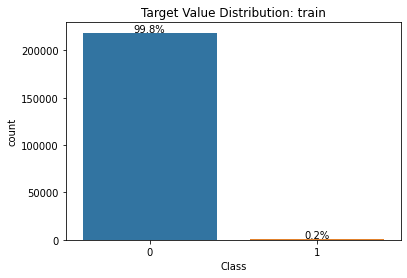

In [14]:
# 향후 시각화 자료에 비율을 표기하는 함수 생성
def show_text_percent_by_targert( ax, total_count, is_show=True,  ):

  persents = list()

  for patch in ax.patches: 
    w = patch.get_width() 
    h = patch.get_height() 
    p = h/total_count * 100 
    persents.append( p )
    
    l = patch.get_x() 
    ax.text(  x=l + w/2,
              y=h + total_count*0.005,
              s=f'{p:1.1f}%',
              ha='center' 
            )
  if is_show:
    if len(persents) == 2:
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4:
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

# train의 정답 비율
ax = sns.countplot( data=train, x='Class');
show_text_percent_by_targert( ax, train.shape[0] )
ax.set_title('Target Value Distribution: train')

타겟값간 비율 577.8760162601625


Text(0.5, 1.0, 'Target Value Distribution: orig_train')

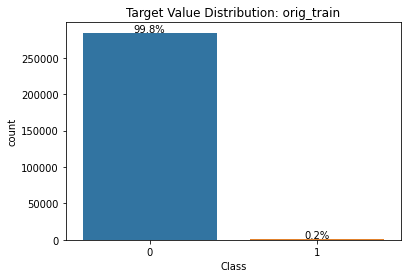

In [13]:
# orig_train의 정답 비율
ax = sns.countplot( data=orig_train, x='Class');
show_text_percent_by_targert( ax, orig_train.shape[0] )
ax.set_title('Target Value Distribution: orig_train')

- 정답의 비율이 0.2%로 매우 적다
- train과 orig_train의 정답 비율은 같다!

### 각 컬럼별 분포도 확인

In [15]:
features = [c for c in train.columns if c not in ['id', 'Class']]
print(features)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


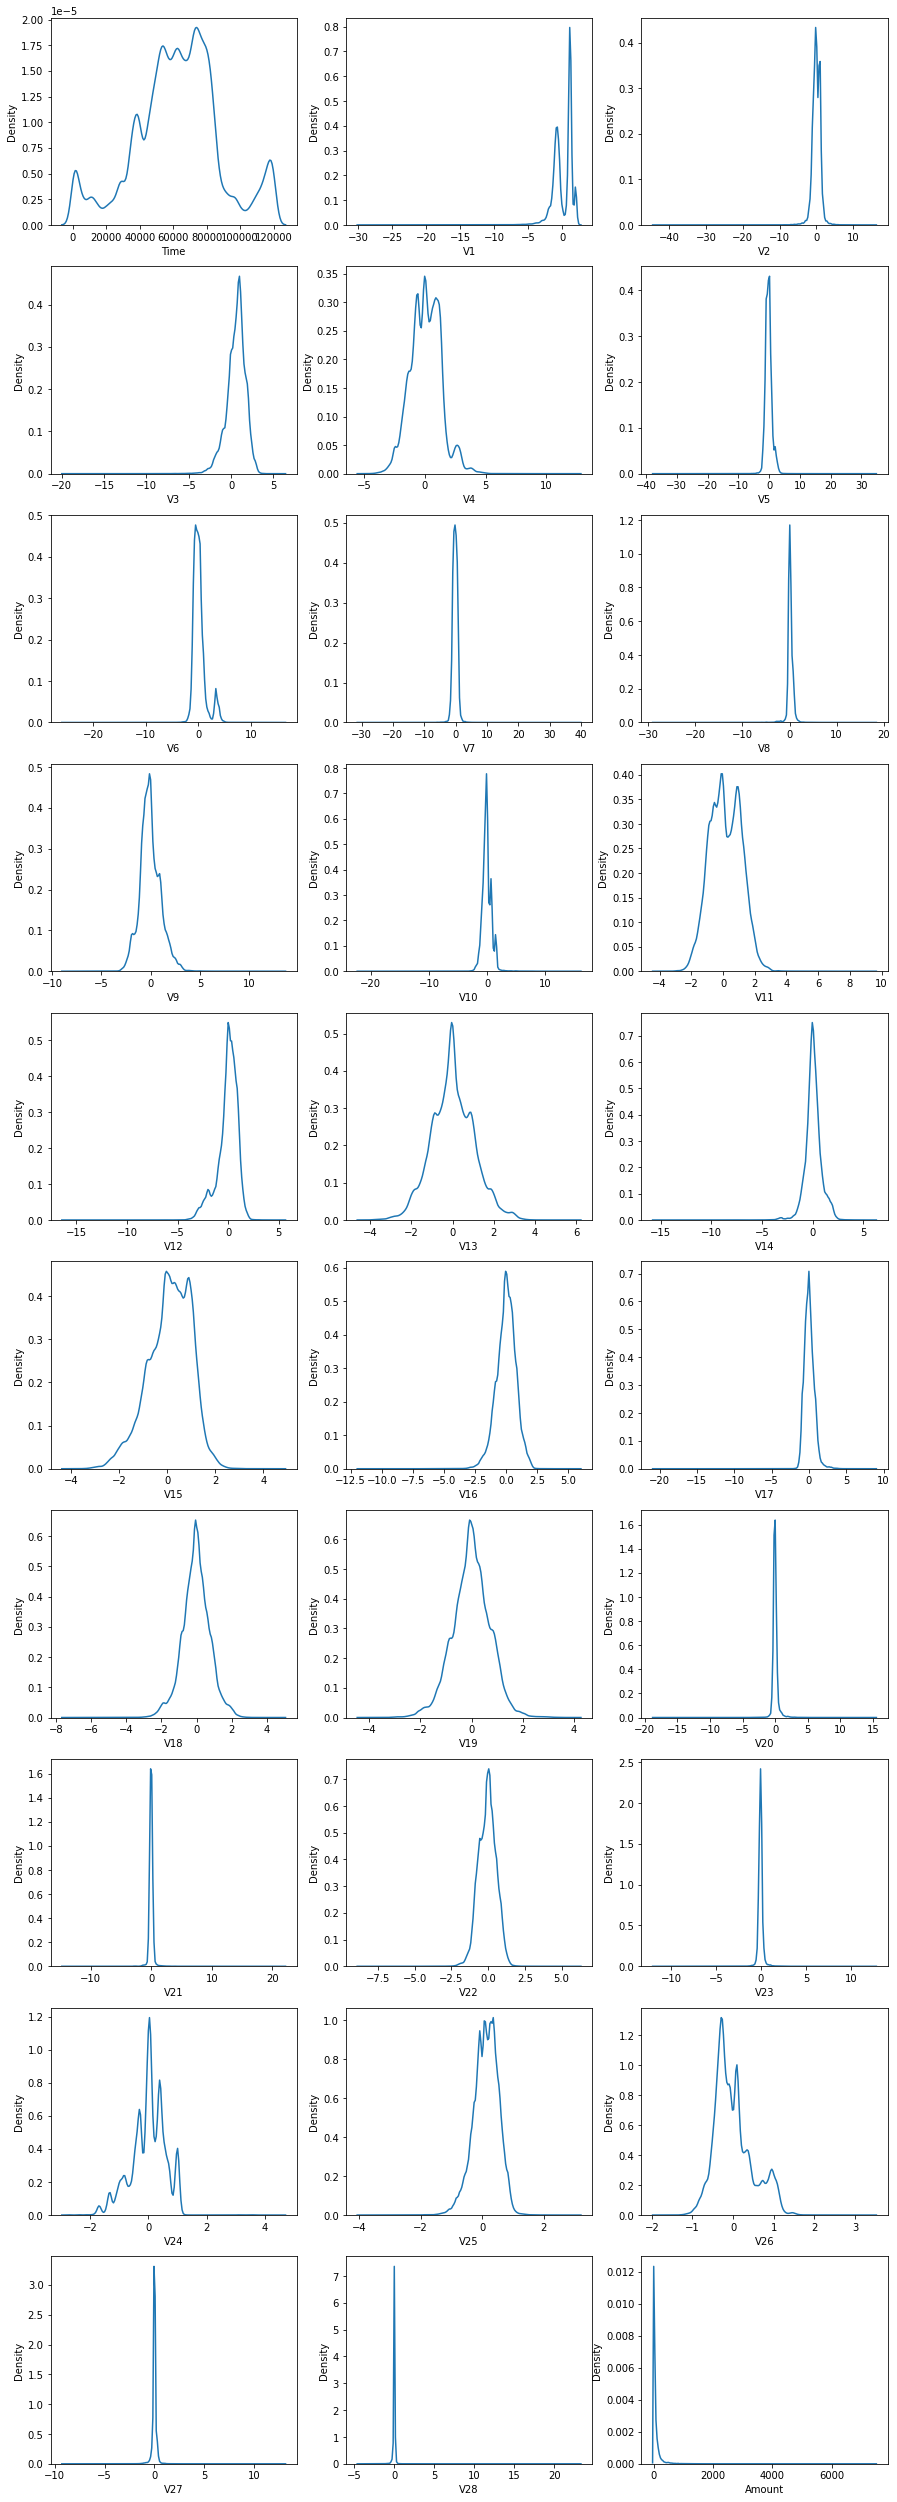

In [16]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 45))

for n in range(30):
    m = n%3
    l = int(n/3)
    sns.kdeplot(ax = axes[l,m], x = features[n],data = train)

### 각 컬럼별 train, test, orig_train 데이터 분포도 확인

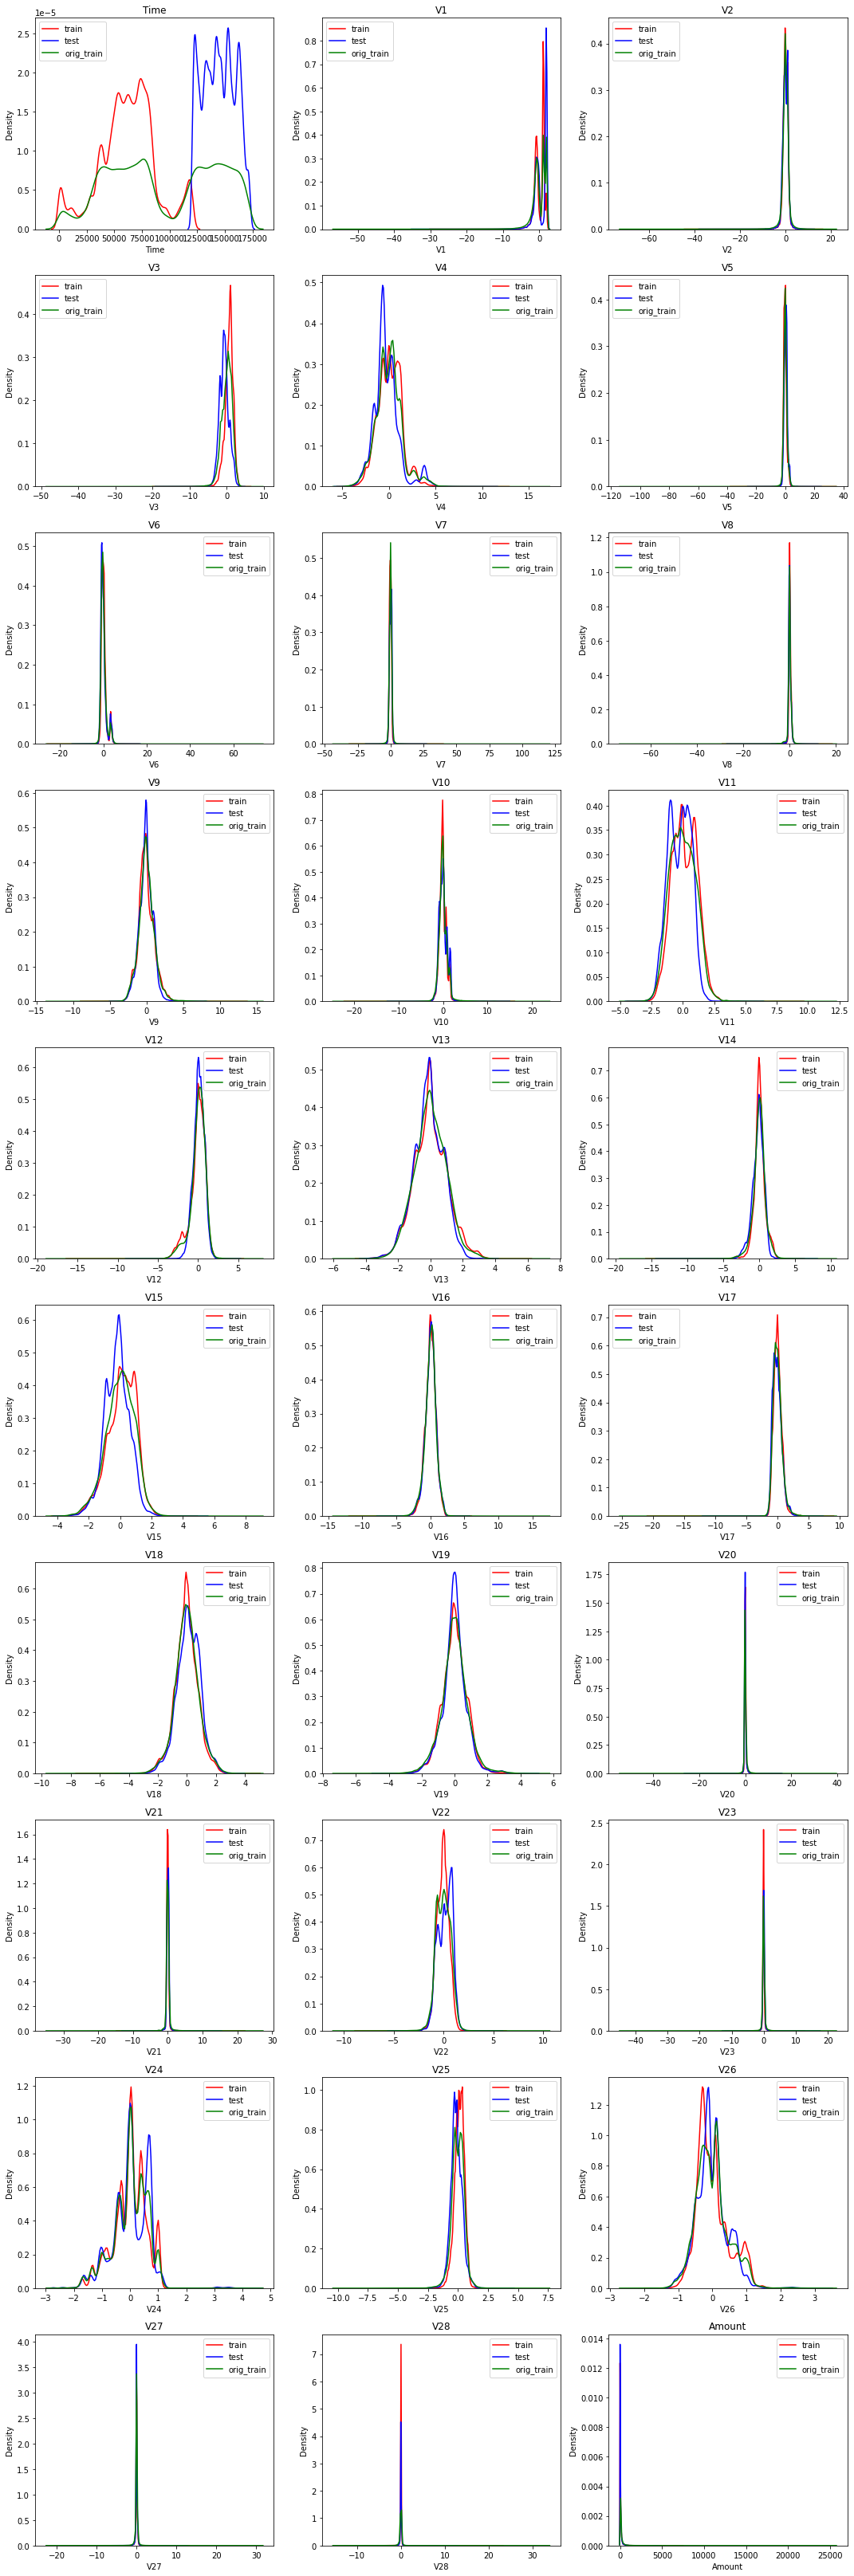

In [17]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 45))
for ax, n in zip(axes.flat, features):
    sns.kdeplot(train[n], color='r', label='train', ax=ax)
    sns.kdeplot(test[n], color='b', label='test', ax=ax)
    sns.kdeplot(orig_train[n], color='g', label='orig_train', ax=ax)
    ax.set_title(n)
    ax.legend()
plt.tight_layout()
plt.show()

### 분석결과

- train 데이터에서 'Time'의 분포도를 확인했을 때, 정규분포를 이루고 있어 학습에 도움이 될 것이라 예상하였다
- 하지만 train, test, orig_train과 비교했더니 'Time'만 분포가 매우 달랐다 => 'Time' 컬럼만 제거 후 orig_train 사용하겠다

# 피처엔지니어링

In [18]:
# train에 original 데이터 병합
train = pd.concat([train,orig_train]).reset_index(drop=True)

In [19]:
train.shape, test.shape

((503936, 31), (146087, 30))

- 총 503936개의 train 데이터와 146087개의 test 데이터를 사용하겠다!

## 스케일링

In [20]:
X = train.iloc[ :, :-1]
y = train.iloc[ :, -1: ]

# 정답을 제외한 피처들
features = [c for c in train.columns if c not in ['id', 'Class']]

# 스케일링
alpha_enc = MinMaxScaler()
temp_alpha = pd.concat( [ train.iloc[:,:-1], test ] )
alpha_enc.fit( temp_alpha )
enc_nom_etc_train = alpha_enc.transform( train.iloc[:,:-1]  )
enc_nom_etc_test  = alpha_enc.transform( test )

train=pd.DataFrame( enc_nom_etc_train)
test=pd.DataFrame( enc_nom_etc_test)

train.columns = features
test.columns = features

# train에 다시 정답 컬럼 추가
train['Class'] = y

In [21]:
# 스케일링 잘 되었다!
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,0.993534,0.765893,0.817704,0.270231,0.764419,0.250853,0.266030,0.782559,0.488345,...,0.556084,0.468613,0.670434,0.367299,0.561546,0.459381,0.415098,0.311915,0.000077,0
1,0.0,0.992251,0.754060,0.828386,0.212276,0.758159,0.260296,0.259085,0.785924,0.458992,...,0.562364,0.508241,0.667416,0.319990,0.551777,0.349548,0.416337,0.312348,0.003270,0
2,0.0,0.959849,0.777858,0.833542,0.232636,0.770210,0.253083,0.271132,0.784476,0.461332,...,0.556213,0.472537,0.667728,0.510412,0.549452,0.439340,0.420654,0.314897,0.000105,0
3,0.0,0.991926,0.765307,0.818972,0.257255,0.764267,0.256496,0.264820,0.785006,0.493295,...,0.559940,0.506309,0.667924,0.376448,0.577951,0.409743,0.415444,0.311625,0.000039,0
4,0.0,0.975723,0.765445,0.858272,0.307071,0.761431,0.274070,0.259637,0.791492,0.486641,...,0.563078,0.538437,0.665848,0.346820,0.592379,0.384149,0.418511,0.313551,0.000039,0


## Time 컬럼 제거

In [22]:
# Time 제거
train = train.iloc[:,1:]
test = test.iloc[:,1:]

In [23]:
train.head(1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.993534,0.765893,0.817704,0.270231,0.764419,0.250853,0.26603,0.782559,0.488345,0.510973,...,0.556084,0.468613,0.670434,0.367299,0.561546,0.459381,0.415098,0.311915,0.000077,0


In [24]:
test.head(1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.994234,0.759959,0.814791,0.221536,0.761399,0.255331,0.259725,0.785138,0.454852,0.513286,...,0.580983,0.565376,0.541871,0.665995,0.308545,0.570999,0.411582,0.416598,0.312679,0.001166


# Optuna를 이용해 최적의 파라미터 찾기

In [25]:
# optuna 설치
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.8 MB/s eta 0:00:00


In [26]:
# 모듈불러오기
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgbm
from tqdm import tqdm

In [27]:
# 함수 생성
def opt(trial):
    # 파라미터 범위 지정
    params = {
        'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 3),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-12, 2, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 5, 25.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 35, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.65, 0.85),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.65),
        'bagging_freq': trial.suggest_int('bagging_freq', 4, 9),
         'min_child_samples': trial.suggest_int('min_child_samples', 40, 90),
         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 90, 150),
        "max_depth": trial.suggest_int("max_depth", 6, 12),

        'num_iterations':10000,
        'learning_rate':0.1
    }

    # KFold 사용
    n=3
    cv = StratifiedKFold(n,shuffle=True, random_state=42)

    # 점수를 담을 그릇 생성
    scores = []

    # Time을 제거했기 때문에 피처들 다시 선언
    features = [c for c in train.columns if c not in ['id', 'Class']]

    for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train['Class'])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, 'Class']
        X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, 'Class']

        # 모델 생성
        model = lgbm.LGBMClassifier(**params)
        # 훈련
        model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds=50, verbose=500)
        # 예측
        y_pred = model.predict_proba(X_val)[:,1]
        # 평가
        score = roc_auc_score(y_val,y_pred)
        # 점수를 그릇에 담기
        scores.append(score)

    return np.mean(scores)

In [28]:
# optuna로 최적의 파라미터 찾는 코드
'''
study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(func=opt, n_trials=100)
study.best_params
'''

"\nstudy = optuna.create_study(direction='maximize', sampler = TPESampler())\nstudy.optimize(func=opt, n_trials=100)\nstudy.best_params\n"

- 최적의 파라미터 : {
      'objective': 'binary',
      'metric': 'auc',
      'num_iterations':300,
      'learning_rate':0.05,
      'scale_pos_weight': 1,
      'lambda_l1': 8.629495026974812e-12,
      'lambda_l2': 9.464608889367986,
      'num_leaves': 39,
      'feature_fraction': 0.6816416268789407,
      'bagging_fraction': 0.6444301272381365,
      'bagging_freq': 8,
      'min_child_samples': 83,
      'min_data_in_leaf': 102,
      'max_depth': 7
}

# 알고리즘 생성, 예측

In [29]:
# KFold 사용
n=5
cv = StratifiedKFold(n,shuffle=True, random_state=42)

# 피처 목록
features = [c for c in train.columns if c not in ['id', 'Class']]

# 점수를 담을 그릇 생성
all_scores = []
# 최종 예측값을 담을 그릇 생성
test_preds = []

for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train['Class'])):
    X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, 'Class']
    X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, 'Class']
    
    # optuna를 이용해 찾은 파라미터
    params={
          'objective': 'binary',
          'metric': 'auc',
          'num_iterations':300,
          'learning_rate':0.05,
          'scale_pos_weight': 1,
          'lambda_l1': 8.629495026974812e-12,
          'lambda_l2': 9.464608889367986,
          'num_leaves': 39,
          'feature_fraction': 0.6816416268789407,
          'bagging_fraction': 0.6444301272381365,
          'bagging_freq': 8,
          'min_child_samples': 83,
          'min_data_in_leaf': 102,
          'max_depth': 7
    }
    
    # 모델 생성
    model = lgbm.LGBMClassifier(**params)
    # 훈련
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds=50, verbose=500)
    # 예측
    y_pred = model.predict_proba(X_val)[:,1]
    # 평가
    score = roc_auc_score(y_val,y_pred)
    # 점수를 그릇에 담기
    all_scores.append(score)
    # 최종 예측
    test_pred = model.predict_proba(test)[:,1]
    # 최종 예측값을 그릇에 담기
    test_preds.append(test_pred)

    print(f'=== Fold {i} ROC AUC Score {score} ===')

print(f'=== Average ROC AUC Score {np.mean(all_scores)} ===')

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[122]	valid_0's auc: 0.897236
=== Fold 0 ROC AUC Score 0.8972356705581066 ===


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[32]	valid_0's auc: 0.89835
=== Fold 1 ROC AUC Score 0.8983501810063456 ===


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[170]	valid_0's auc: 0.889852
=== Fold 2 ROC AUC Score 0.889851555122024 ===


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[70]	valid_0's auc: 0.906923
=== Fold 3 ROC AUC Score 0.9069226643139984 ===


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[158]	valid_0's auc: 0.896967
=== Fold 4 ROC AUC Score 0.8969670564309029 ===
=== Average ROC AUC Score 0.8978654254862756 ===


# 제출

In [30]:
submission['Class'] = np.array(test_preds).mean(axis=0)
submission.to_csv('submission.csv', index=False)

In [31]:
!jupyter nbconvert --to markdown "/content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종.ipynb to markdown
[NbConvertApp] Support files will be in 분류4번 최종_files/
[NbConvertApp] Making directory /content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종_files
[NbConvertApp] Making directory /content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종_files
[NbConvertApp] Making directory /content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종_files
[NbConvertApp] Making directory /content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종_files
[NbConvertApp] Writing 60186 bytes to /content/drive/MyDrive/cloud_ai/프로젝트2/분류4번 최종.md
